In [2]:
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
from keras import backend as k
from keras.layers import Lambda
from tensorflow.keras.metrics import binary_crossentropy
import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import layers, Input, Model
from extra_keras_datasets import kmnist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv("data.csv")

In [7]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,0.4675,0.893378,1.000000,0.435789,0.974638,0.536341,0.625000,0.940223,0.548628,0.670863,...,0.697605,0.697605,0.881491,0.832707,0.458221,0.255367,0.340862,0.697605,0.697605,0.0
1,0.3925,0.930415,0.686837,0.423158,0.974638,0.330827,0.371711,0.660588,0.488778,0.955036,...,0.751497,0.751497,0.221039,0.234962,0.778976,0.418079,0.511294,0.751497,0.751497,0.0
2,0.5700,0.976431,0.541401,0.635789,0.971014,0.684211,0.855263,0.924012,0.436409,0.956835,...,0.646707,0.646707,0.829561,0.759398,0.654987,0.316384,0.412731,0.646707,0.646707,0.0
3,0.4525,0.866442,0.843949,0.423158,0.931159,0.295739,0.463816,0.880446,0.650873,0.514388,...,0.592814,0.592814,0.810919,0.733083,0.617251,0.231638,0.332649,0.592814,0.592814,0.0
4,0.2400,0.099888,0.167728,0.303158,0.276268,0.393484,0.375000,0.831814,0.553616,0.773381,...,0.389222,0.389222,0.737683,0.330827,0.469003,0.359322,0.466119,0.389222,0.389222,0.0


In [8]:
x = np.array(data.drop(["365"], axis=1))
x

array([[0.4675    , 0.89337823, 1.        , ..., 0.34086242, 0.69760479,
        0.69760479],
       [0.3925    , 0.93041526, 0.68683652, ..., 0.51129363, 0.75149701,
        0.75149701],
       [0.57      , 0.97643098, 0.54140127, ..., 0.41273101, 0.64670659,
        0.64670659],
       ...,
       [0.4575    , 0.22558923, 0.53821656, ..., 0.41683778, 0.38922156,
        0.38922156],
       [0.1425    , 0.03479237, 0.3492569 , ..., 0.35112936, 0.73652695,
        0.73652695],
       [0.185     , 0.14365881, 0.46072187, ..., 0.06365503, 0.5988024 ,
        0.5988024 ]])

In [5]:
y = np.array(data["365"])

In [6]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True,
                                   test_size=0.30, random_state=42)

In [8]:
x_train[0].shape[0]

365

In [9]:
def sampling(args):
    mu, log_var = args
    eps = k.random_normal(shape=(keras.backend.shape(mu)[0], latent_dim), mean=0., stddev=1.0)
    return mu + k.exp(log_var) * eps

In [10]:
batch_size, n_epoch = 8, 100
latent_dim = 10

input_vector = Input(shape=(x_train[0].shape[0]))
x = Dense(200, activation='LeakyReLU')(input_vector)
x= Dense(150, activation='LeakyReLU')(x)
x = Dense(60, activation='LeakyReLU')(x)

mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

z = layers.Lambda(sampling)([mu, log_var])

encoder = Model(input_vector, z, name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 365)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          73200       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 150)          30150       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 60)           9060        ['dense_1[0][0]']                
                                                                                            

In [11]:
z_decoder1 = Dense(60, activation='LeakyReLU')
z_decoder2 = Dense(150, activation='LeakyReLU')
z_decoder3 = Dense(200, activation='LeakyReLU')
y_decoder = Dense((x_train[0].shape[0]), activation='softmax')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

In [12]:
mu_avg = (mu + 0)/2
log_var_avg = (log_var + 1)/2

In [13]:
reconstruction_loss = binary_crossentropy(input_vector, y) * x_train[0].shape
jsd_loss = 0.5 * (k.sum(0.5 * k.square(mu - mu_avg) / k.exp(log_var_avg), axis=-1)
                 + k.sum(0.5 * (k.exp(log_var) / k.exp(log_var_avg) - k.log(k.exp(log_var) / k.exp(log_var_avg)) - 1), axis=-1))

vae_loss = reconstruction_loss + jsd_loss

vae = Model(input_vector, y, name='VAE')
vae.add_loss(vae_loss)

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 365)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          73200       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 150)          30150       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 60)           9060        ['dense_1[0][0]']                
                                                                                                

 )                                                                                                
                                                                                                  
 tf.math.reduce_sum_1 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)                                                                                              
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (None,)             0           ['tf.keras.backend.binary_crossen
 a)                                                              tropy[0][0]']                    
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None,)             0           ['tf.math.reduce_sum[0][0]',     
 mbda)                                                            'tf.math.reduce_sum_1[0][0]']   
          

In [14]:
vae.compile(optimizer='Adam')
history = vae.fit(x_train, shuffle=True, epochs=n_epoch, batch_size=batch_size, validation_data=(x_test, None), verbose=1)

Epoch 1/100
5/5 [==============================] - 2s 51ms/step - loss: 252.1291 - val_loss: 247.8687
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 244.4521 - val_loss: 241.0186
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 240.0542 - val_loss: 237.5404
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 237.2753 - val_loss: 239.4790
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 237.0189 - val_loss: 238.5107
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 237.2945 - val_loss: 238.4201
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 236.2484 - val_loss: 237.3696
Epoch 8/100
5/5 [==============================] - 0s 12ms/step - loss: 236.1858 - val_loss: 237.3760
Epoch 9/100
5/5 [==============================] - 0s 12ms/step - loss: 235.7091 - val_loss: 236.6725
Epoch 10/100
5/5 [==============================] - 0s 12ms/step - loss: 235.8568 

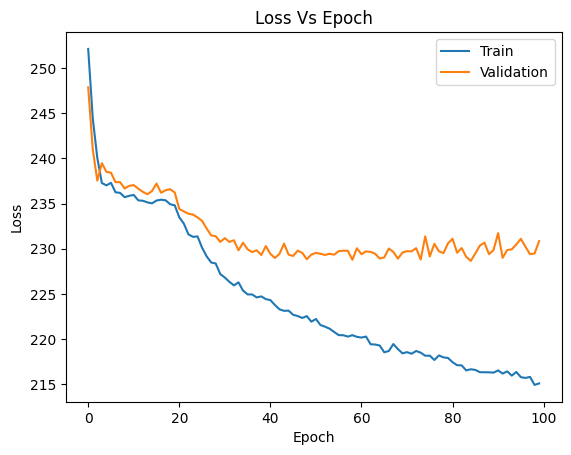

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

3/3 [==============================] - 0s 0s/step


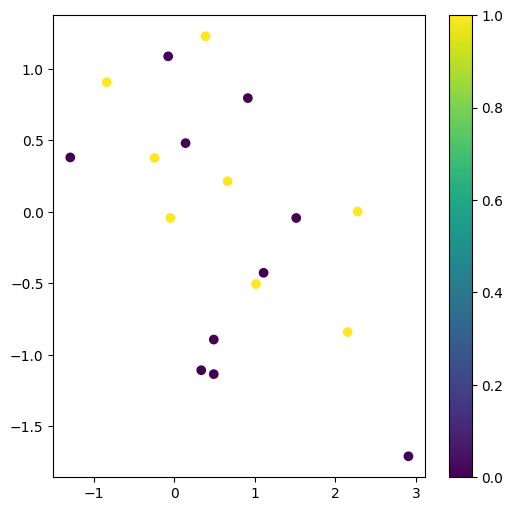

In [16]:
x_te_latent = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [17]:
decoded_vector = vae.predict(x_test, batch_size=batch_size)

3/3 [==============================] - 0s 3ms/step


Orignal Image:


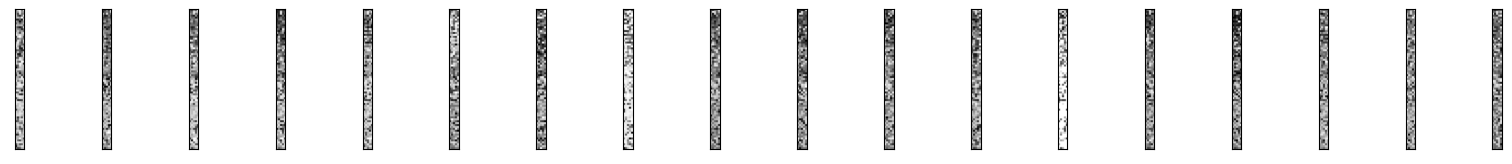

In [18]:
n = len(x_test)

print('Orignal Image:')
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(73,5))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reconstructed Image:


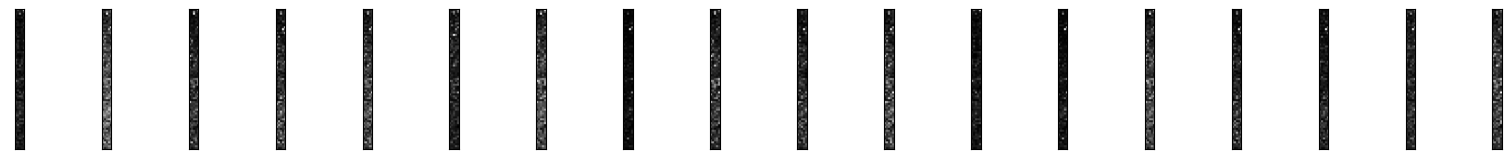

In [19]:
n = len(x_test)
print('Reconstructed Image:')
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_vector[i].reshape(73,5))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
encoder.trainable = False

In [21]:
cls1 = Dense(100, activation='LeakyReLU')
cls2 = Dense(50, activation='LeakyReLU')
cls3 = Dense(2, activation='sigmoid')

CL1 = cls1(z)
CL2 = cls2(CL1)
CL3 = cls3(CL2)

In [22]:
vaec = Model(input_vector, CL3, name='VAEc')
vaec.summary()

Model: "VAEc"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 365)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 200)          73200       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 150)          30150       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 60)           9060        ['dense_1[0][0]']                
                                                                                               

In [23]:
from tensorflow.keras.optimizers import Adam
opt = Adam()

# Configuring the model for training
vaec.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Label encoding y
lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)

# Converting it into a categorical variable
y_train = to_categorical(y_train)

y_test = lbl.fit_transform(y_test)

# Converting it into a categorical variable
y_test = to_categorical(y_test)

In [25]:
history_2 = vaec.fit(x_train,y_train,epochs=40,batch_size=8,validation_split=0.2)

Epoch 1/40
4/4 [==============================] - 2s 114ms/step - loss: 0.8504 - accuracy: 0.4062 - val_loss: 0.8795 - val_accuracy: 0.3750
Epoch 2/40
4/4 [==============================] - 0s 18ms/step - loss: 0.6638 - accuracy: 0.5938 - val_loss: 0.8172 - val_accuracy: 0.6250
Epoch 3/40
4/4 [==============================] - 0s 18ms/step - loss: 0.5879 - accuracy: 0.6562 - val_loss: 0.7320 - val_accuracy: 0.7500
Epoch 4/40
4/4 [==============================] - 0s 17ms/step - loss: 0.5473 - accuracy: 0.7500 - val_loss: 0.6474 - val_accuracy: 0.7500
Epoch 5/40
4/4 [==============================] - 0s 16ms/step - loss: 0.5136 - accuracy: 0.7188 - val_loss: 0.6322 - val_accuracy: 0.7500
Epoch 6/40
4/4 [==============================] - 0s 15ms/step - loss: 0.4942 - accuracy: 0.7500 - val_loss: 0.5544 - val_accuracy: 0.7500
Epoch 7/40
4/4 [==============================] - 0s 17ms/step - loss: 0.4678 - accuracy: 0.6875 - val_loss: 0.4932 - val_accuracy: 0.6250
Epoch 8/40
4/4 [==========

In [26]:
len(x_train[0])

365

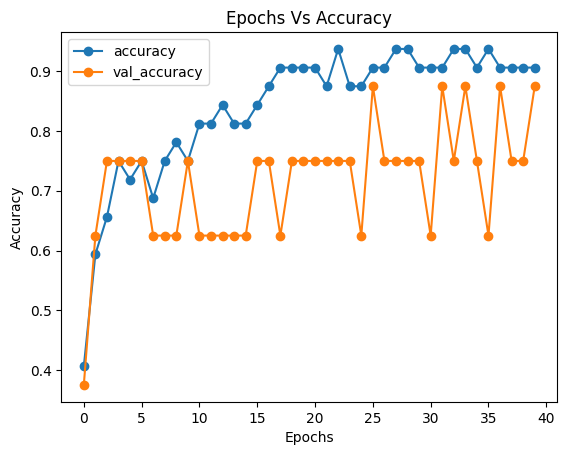

In [27]:
plt.plot(np.array((history_2.history)['accuracy']),'-o')
plt.plot(np.array((history_2.history)['val_accuracy']),'-o')
plt.title("Epochs Vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'])
plt.show()

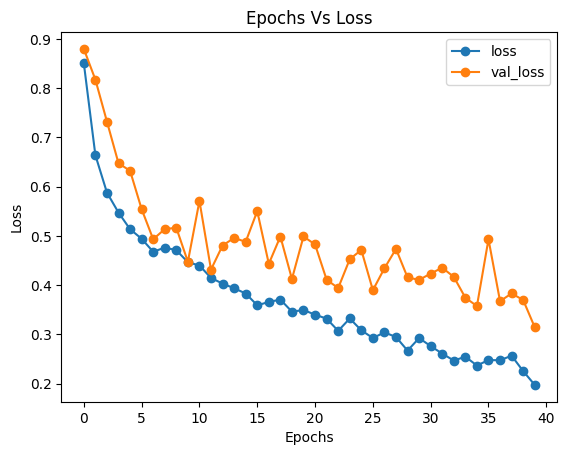

In [28]:
plt.plot(np.array((history_2.history)['loss']),'-o')
plt.plot(np.array((history_2.history)['val_loss']),'-o')
plt.title("Epochs Vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss','val_loss'])
plt.show()

In [29]:
predictions = vaec.predict(x_test)

1/1 [==============================] - 0s 159ms/step


In [41]:
test_loss, test_acc = vaec.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 27ms/step - loss: 0.6024 - accuracy: 0.7778
Test loss: 0.6023852825164795
Test accuracy: 0.7777777910232544


In [31]:
y_pred = [np.argmax(np.round(predictions[i])) for i in range(len(x_test))]
y_true = [np.argmax(y_test[i]) for i in range(len(x_test))]

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

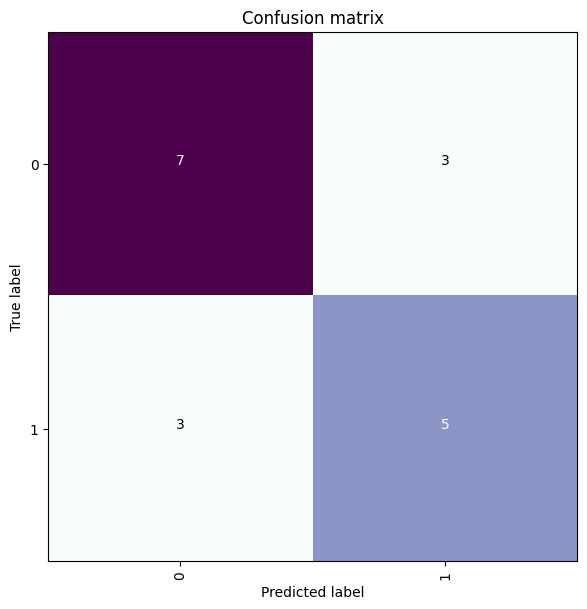

In [33]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_true,y_pred)
cm_plot = plot_confusion_matrix(cm,classes=[str(i) for i in {0,1}])

In [34]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)